<img src="imgs/mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Data preprocessing</center>

# Worksheet S4: Data augmentation

**¿Qué es data augmentation?**

Data augmentation es una etapa más del preprocesamiento. Esta etapa busca solucionar un problema muy común en el mundo real cuando trabajamos con datos: tenemos ejemplos insuficientes, los datos están totalmente desbalanceados o simplemente los ejemplos que tenemos no contienen información suficiente una representación completa del problema a analizar.

<img src="imgs/gatos.png" style="height: 200px">

En resumen, data augmentation responde y soluciona la pregunta: **¿Cómo consigo más datos o mejoro los actuales si no tengo más datos?**

In [10]:
# instalar requisitos
import sys
!{sys.executable} -m pip install imbalanced-learn scikit-learn scikit-image

     |████████████████████████████████| 163kB 4.0MB/s eta 0:00:01


In [2]:
# preparación del entorno
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)

Vamos a trabajar con un dataset que contiene información sobre el tipo transmisiones de alerta de seguridad realizados entre dos dispositivos IOT conectados a internet. Estas transmisiones pueden haber sido interceptadas en el camino o simplemente simuladas por un hacker con malas intenciones.

In [3]:
# carga del dataset
alerts = pd.read_csv("data/alerts.csv")
alerts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   distance    400 non-null    float64
 1   confidence  400 non-null    float64
 2   class       400 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 9.5 KB


In [4]:
alerts.head()

,distance,confidence,class
0,0.435845,-0.656479,0
1,0.214585,-1.571423,0
2,0.371736,0.379228,0
3,-0.739102,-0.378166,0
4,1.801530,-0.197758,0


In [4]:
alerts['class'].value_counts()

0    360
1     40
Name: class, dtype: int64

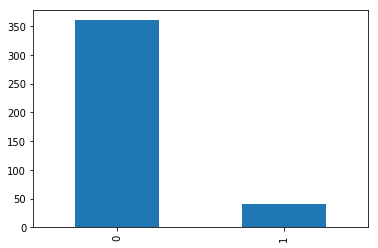

In [5]:
alerts['class'].value_counts().plot(kind='bar')

Como podemos observar:
* Hay 360 transmisiones de origen seguro. 
* Hay 40 transmisiones de origen fraudulento.

Vamos a dar un vistazo con una gráfica.

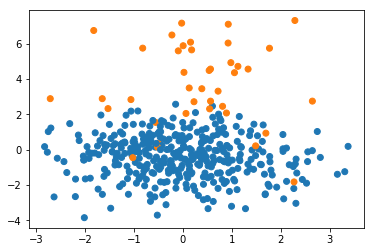

In [13]:
colors = alerts['class'].map({0 : "#1f77b4", 1: "#ff7f0e"})
plt.scatter(x = alerts['confidence'], y = alerts['distance'], c=colors)

Como ya hemos podido deducir, es un dataset desbalanceado, donde las transmisones fraudulentas, son las minoritarias. Sin embargo, estas son las que más nos interesan. Supongamos que queremos desarrollar un método para inequívocamente, definir si un aviso es una alarma o no. 

Para poder desarrollar este sistema, utilizaremos un algoritmo que aprenderá a base de ejemplos. Pero es obvio que necesitamos más ejemplos del tipo minoritario por dos motivos:
* Las transmisiones que más nos interesa identificar son las fraudulentas.
* Necesitamos asegurarnos que nuestro sistema reconoce este tipo de transmisiones perfectamente y son las de menor número.

**Necesitamos balancear nuestro dataset.**

Entre las técnicas de data augmentation más intuitivas se encuentran oversampling y undersampling. Vamos a dar un vistazo a cada una de ellas y aplicarlas a nuestro dataset. Para ello, haremos uso del paquete _imbalanced learn_, parte de scikit learn.

### Undersampling

Undersampling consiste en eliminar la diferencia en el balanceo mediante la eliminación aleatoria de datos, hasta conseguir un dataset que mantenga una proporción equilibrada de puntos.

In [11]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state = 0)
rus.fit_sample(alerts[['confidence', 'distance']], alerts[['class']])
print('Filas que nos quedamos:', len(rus.sample_indices_))

Using TensorFlow backend.


Filas que nos quedamos: 80


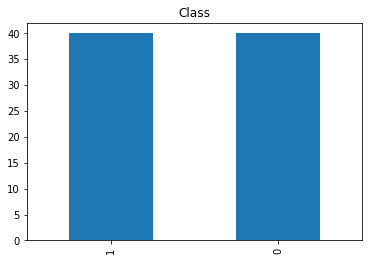

In [12]:
alerts_undersampled = alerts.iloc[rus.sample_indices_]
alerts_undersampled['class'].value_counts().plot(kind='bar', title='Class')

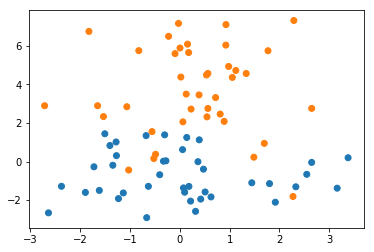

In [10]:
colors = alerts_undersampled['class'].map({0 : "#1f77b4", 1: "#ff7f0e"})
plt.scatter(
    x = alerts_undersampled['confidence'], 
    y = alerts_undersampled['distance'], 
    c=colors
)

Parece que ya tenemos un dataset balanceado.

* ¿Cómo pensáis que afectará este método al resultado?
* ¿Cómo mejoraríais el método?

### Tomek Undersampling

Tomek Undersampling hace uso de una técnica llamada Tomek Links que descubre aquellos pares de puntos, cada uno de una clase, que están más cercanos entre ellos. Con esto, se seleccionarán estos puntos como candidatos a la hora de realizar el undersampling.

In [36]:
from imblearn.under_sampling import TomekLinks

tlu = TomekLinks()
tlu.fit_sample(alerts[['confidence', 'distance']], alerts[['class']])

print('Filas que nos quedamos:', len(tlu.sample_indices_))

Filas que nos quedamos: 391


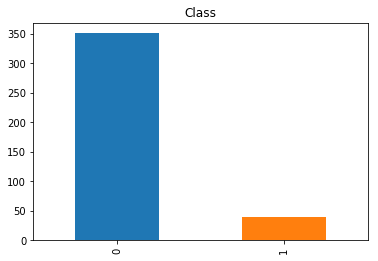

In [37]:
alerts_tomek = alerts.iloc[tlu.sample_indices_]
alerts_tomek['class'].value_counts().plot(kind='bar', title='Class')

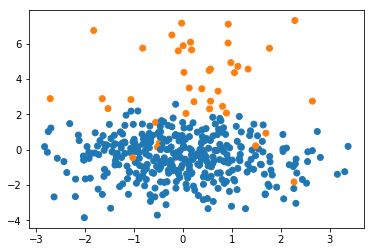

In [13]:
colors = alerts_tomek['class'].map({0 : "#1f77b4", 1: "#ff7f0e"})
plt.scatter(x = alerts_tomek['confidence'], y = alerts_tomek['distance'], c=colors)

Mostramos el dataset original para comparar mejor...

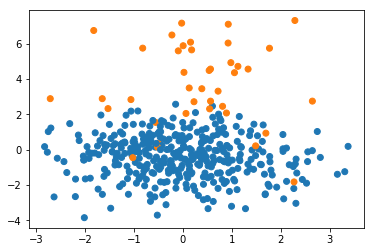

In [14]:
colors = alerts['class'].map({0 : "#1f77b4", 1: "#ff7f0e"})
plt.scatter(x = alerts['confidence'], y = alerts['distance'], c=colors)

Como ves, las cuentas no han cuadrado con los resultados que nos esperábamos. Esto es porque un TomekLink es sólo considerado como tal si y solo si:
* El punto A es el punto más cercano al punto B.
* El punto B es el punto más cercano al punto A.
* El punto A y el punto B son de clases diferentes.

### Edited KNN Undersampling

KNN o K-Nearest Neighbors es un algoritmo que busca vecinos de un punto en nuestro dataset, tanto para decidir si pertenece a un tipo o para identificar un grupo de puntos concreto. Es un algoritmo clásico pero clave en Machine Learning y que veréis pronto.

Imblearn tiene este algoritmo aplicado a Undersampling. Busca vecinos de los puntos que hemos identificado como clase minoritaria y elimina los N vecinos más cercanos.

In [15]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours(n_neighbors = 3)
enn.fit_sample(alerts[['confidence', 'distance']], alerts[['class']])
print('Filas que nos quedamos:', len(enn.sample_indices_))

Filas que nos quedamos: 368


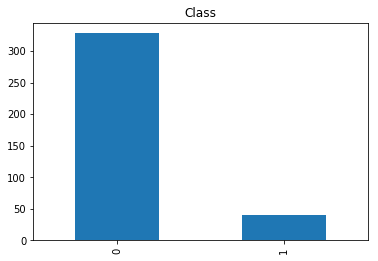

In [16]:
alerts_enn = alerts.iloc[enn.sample_indices_]
alerts_enn['class'].value_counts().plot(kind='bar', title='Class')

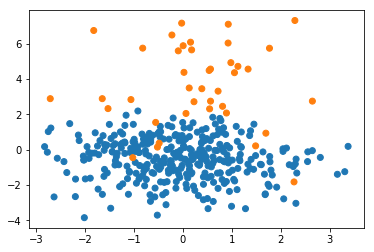

In [17]:
colors = alerts_enn['class'].map({0 : "#1f77b4", 1: "#ff7f0e"})
plt.scatter(x = alerts_enn['confidence'], y = alerts_enn['distance'], c=colors)

Para entender el comportamiento de Edited KNN hay que saber cómo toma las decisiones:
* Para cada punto, calcula sus N vecinos.
* Si el punto actual es de la clase mayoritaria, pero los N vecinos representan por mayoría a otra clase, el punto actual se elimina del dataset.
* Si el punto actual es de la clase minoritaria, pero los N vecinos representan por mayoría a otra clase, los vecinos de la clase mayoritaria se eliminan del dataset.

Como has visto, los resultados difieren en gran medida.

* ¿Qué piensas de los resultados obtenidos?
* ¿Que ventajas y desventajas crees que tienen los métodos?

### Oversampling

Oversampling es la técnica contraria a undersampling: generar datos sintéticos nuevos que nos ayuden a tener un dataset más completo. En este caso es obvio que tendremos que aplicar oversampling a la clase minoritaria.

In [18]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = 0)
ros.fit_sample(alerts[['confidence', 'distance']], alerts[['class']])
print('Filas que nos quedamos:', len(ros.sample_indices_))

Filas que nos quedamos: 720


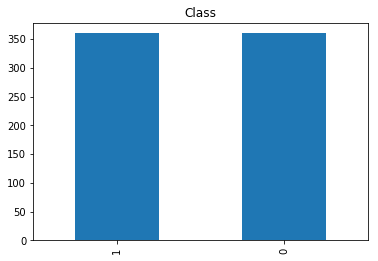

In [19]:
alerts_ros = alerts.iloc[ros.sample_indices_]
alerts_ros['class'].value_counts().plot(kind='bar', title='Class')

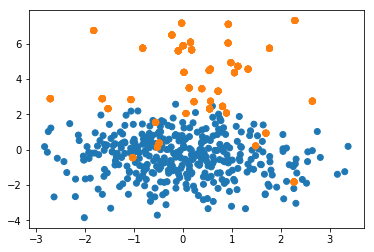

In [20]:
colors = alerts_ros['class'].map({0 : "#1f77b4", 1: "#ff7f0e"})
plt.scatter(x = alerts_ros['confidence'], y = alerts_ros['distance'], c=colors)

El scatterplot parece exactamente el mismo, sin embargo parece que el histograma sí que muestra nuestro oversampling.
¿Qué ha ocurrido? ¿Por qué motivo?

### SMOTE

SMOTE, o Synthetic Minority Over-sampling Technique es un método de oversampling de datos más elaborado que RandomOversampling. SMOTE también hace uso de el algoritmo KNN mencionado anteriormente. El proceso consiste en tres pasos diferenciados:
* Para cada punto de la clase minoritaria _Xi_, encontrará sus K vecinos de la clase minoritaria más cercanos.
* Una vez encontrados los vecinos, se selecciona un vecino al azar _Xzi_ y se establece una línea entre ambos puntos.
* Se genera un dato sintético en esa línea de la clase minoritaria _Xnew_.

Esto se entiende mucho mejor con una imagen.

<img src="imgs/smote.png" style="height: 300px, width: 500px">

Aplicar SMOTE en nuestro dataset es muy sencillo con imblearn.

In [21]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X, y = smote.fit_sample(alerts[['confidence', 'distance']], alerts[['class']])

# convertimos a DataFrame por comodidad y renombramos las columnas de datos en X a los nombres que teníamos previamente.
alerts_smote = pd.DataFrame(X).rename(columns = {0 : 'confidence', 1 : 'distance'})
alerts_smote['class'] = y

print("Datos después de SMOTE: {}".format(len(y)))

Datos después de SMOTE: 720


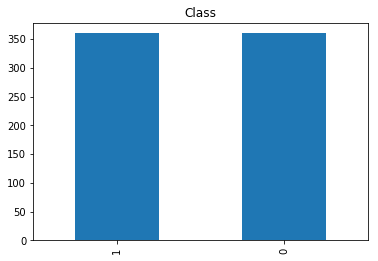

In [22]:
alerts_smote['class'].value_counts().plot(kind='bar', title='Class')

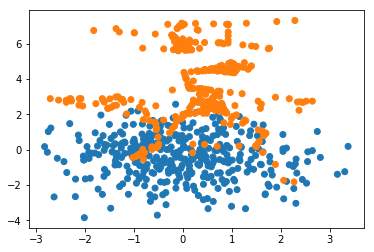

In [23]:
colors = alerts_smote['class'].map({0 : "#1f77b4", 1: "#ff7f0e"})
plt.scatter(x = alerts_smote['confidence'], y = alerts_smote['distance'], c=colors)

Una práctica típica es aplicar primero Random Undersampling sobre la clase mayoritaria y posteriormente aplicar SMOTE sobre la clase minoritaria.

### ADASYN

ADASYN es otro algoritmo de oversampling que también hace uso de una técnica similar al SMOTE en cuanto a que genera datos sintéticos haciendo uso de los vecinos de los datos originales.

Sin embargo hay una diferencia: mientras que SMOTE no tiene consideración alguna por generar datos en posición, ADASYN se centra en generar los datos basando en las densidades de clase. Esto significa que generará más datos sintéticos en regiones donde la densidad de la clase minoritaria sea baja, y menos donde la densidad sea alta.

Esto puede ayudar a generar datos donde precisamente, las decisiones para un algoritmo, son más dificiles de tomar dentro de un dataset. Vamos a verlo con un ejemplo.

In [24]:
from imblearn.over_sampling import ADASYN
ada = ADASYN()
X, y = ada.fit_sample(alerts[['confidence', 'distance']], alerts[['class']])

# convertimos a DataFrame por comodidad y renombramos las columnas de datos en X a los nombres que teníamos previamente.
alerts_ada = pd.DataFrame(X).rename(columns = {0 : 'confidence', 1 : 'distance'})
alerts_ada['class'] = y

print("Datos después de ADASYN: {}".format(len(y)))

Datos después de ADASYN: 721


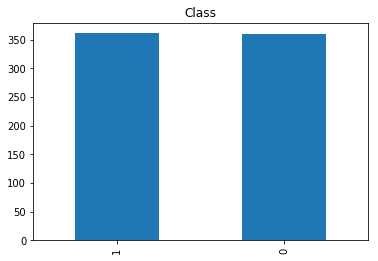

In [25]:
alerts_ada['class'].value_counts().plot(kind='bar', title='Class')

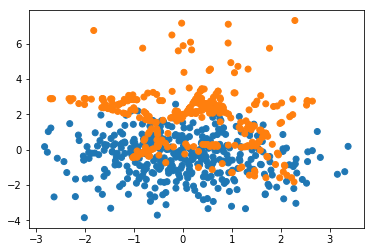

In [26]:
colors = alerts_ada['class'].map({0 : "#1f77b4", 1: "#ff7f0e"})
plt.scatter(x = alerts_ada['confidence'], y = alerts_ada['distance'], c=colors)

* ¿Qué te parecen estos métodos? 
* ¿Que problemas y ventajas crees que tendrán?

## Data augmentation con imágenes

Deep Learning ha supuesto un avance enorme para el procesado de imágenes. Con ello, ha aumentado la necesidad de datos y no siempre se pueden obtener en la forma y contexto que se desearía. Por ello, data augmentation es muy importante en este campo.

Hay que tener en cuenta que no todo vale, puesto que si estamos trabajando en un sistema de reconocimiento de personas en un sistema de alerta, no tiene sentido enterenar nuestro sistema con imágenes de personas que caminan por las paredes o el cielo. Las transformaciones pueden ser muy variadas, pero estas son las más habituales. Aprenderéis mucho más en la asignatura de visión por computador :)

In [27]:
from skimage import io, transform
import numpy as np
img = io.imread("imgs/gcat.jpg")
print("Dimensión Y: {}, Dimensión X: {}, Canales: {}".format(img.shape[0], img.shape[1], img.shape[2]))

Dimensión Y: 205, Dimensión X: 300, Canales: 3


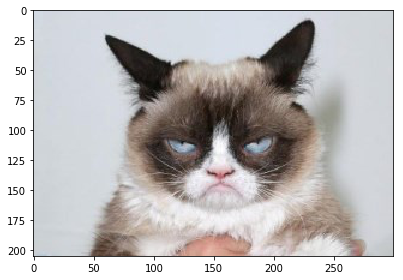

In [28]:
io.imshow(img)

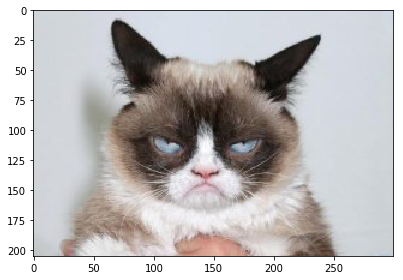

In [29]:
io.imshow(np.fliplr(img))

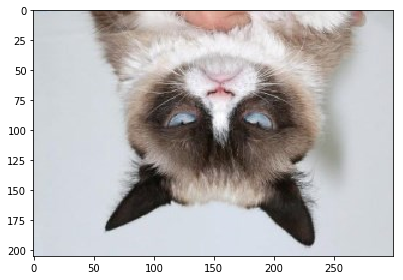

In [30]:
io.imshow(np.flipud(img))

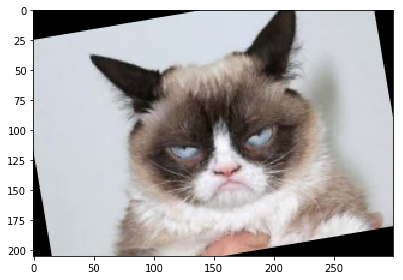

In [31]:
io.imshow(transform.rotate(img, 10, resize=False))

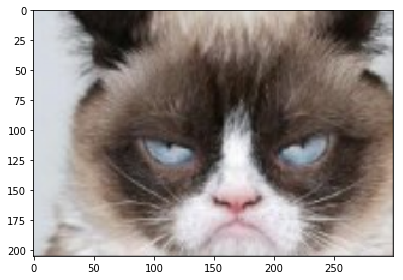

In [32]:
startx = 60
starty = 50    
cropped =  img[starty:starty+110,startx:startx+170, :]
io.imshow(transform.resize(cropped, (205, 300)))

* ¿Qué otras técnicas crees que se podrían aplicar en imágenes?